# EDA

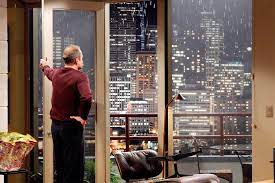

In [29]:
#Suppress Warnings:
import warnings

warnings.filterwarnings("ignore")
#Data Manipulation: Using pandas and numpy to handle and process data efficiently.
#Visualization: matplotlib and seaborn 
#Import Libraries:
import pandas as pd # For data manipulation and analysis.
import numpy as np # For numerical operations.
import matplotlib.pyplot as plt # For creating static, animated, and interactive visualizations.
import seaborn as sns # For statistical data visualization built on top of matplotlib.

#Configure Plotting Settings:
from matplotlib.ticker import PercentFormatter #Used for formatting axis labels as percentages.
plt.rcParams.update({ "figure.figsize" : (8, 5),"axes.facecolor" : "white", "axes.edgecolor":  "black"}) #Updates the default settings for matplotlib plots
plt.rcParams["figure.facecolor"]= "w"
pd.plotting.register_matplotlib_converters() #Register Matplotlib Converters:
pd.set_option('display.float_format', lambda x: '%.3f' % x) #Set Display Options for Pandas:

In [30]:
#Connecting and retrieving data via SQLAlchemy
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker
import pandas as pd

#If you haven't already installed the python-dotenv package, you can install it using pip:
#You need to import the load_dotenv function from the dotenv module in your script. 
#Add the following import statement at the top of your script:
import os
from dotenv import load_dotenv

# create query strings to retrieve the Data
query_string_sales = "SELECT * FROM eda.king_county_house_sales"
query_string_details = "SELECT * FROM eda.king_county_house_details"

# Load environment variables from .env file
load_dotenv()

#get the Database String read
DB_STRING = os.getenv('DB_STRING')

# Setup the engine and session
engine = create_engine(DB_STRING)
Session = sessionmaker(bind=engine)
session = Session()

try:
    # Load data into a DataFrame
    df_h_sales = pd.read_sql(query_string_sales, engine)
    df_h_details = pd.read_sql(query_string_details, engine)
finally:
    session.close()  # Make sure to close the session

In [31]:
#export the data to a csv-file
df_h_details.to_csv('data/eda-house-details.csv',index=False)
df_h_sales.to_csv('data/eda-house-sales.csv', index=False)

In [32]:
#import the data from the csv-file
df_h_sales = pd.read_csv('data/eda-house-sales.csv')
df_h_details = pd.read_csv('data/eda-house-details.csv')

In [33]:
# Convert 'date' column to datetime
df_h_sales['date'] = pd.to_datetime(df_h_sales['date'])

In [34]:
# Merge DataFrames on house_id and id
df_combined = pd.merge(df_h_sales, df_h_details, left_on='house_id', right_on='id')

In [35]:
from datetime import datetime, timedelta

# Convert 'date' column to datetime
df_combined['date'] = pd.to_datetime(df_combined['date'])

In [36]:
# Find the latest date
latest_date = df_h_sales['date'].max()
date_cutoff = latest_date - timedelta(days=2*365)  # Approximate 2 years

In [37]:
# Filter DataFrame based on buyer requirements
#Thomas Hansen 	
# Buyer 	5 kids, no money, wants nice (social) neighborhood, Timing?, Location?
filtered_df = df_combined[
    (df_combined['bedrooms'] >= 4) &
    (df_combined['bathrooms'] >= 2) &
    (df_combined['price'] <= 500000) &
    (df_combined['zipcode'].isin([98101, 98102, 98103, 98104])) &
    (df_combined['date'] >= date_cutoff)
]

In [38]:
# Sort DataFrame by 'date' in descending order
sorted_df = filtered_df.sort_values(by='date', ascending=False)

In [39]:
# List of columns to drop (update this based on actual column names)
columns_to_drop = ['id_x', 'id_y', 'sqft_living15', 'sqft_lot15']

# Drop specified columns, only if they exist
columns_to_drop_existing = [col for col in columns_to_drop if col in sorted_df.columns]

# Drop the columns
sorted_df = sorted_df.drop(columns=columns_to_drop_existing)

In [40]:
# Specify the path where you want to save the sorted data in CSV file
file_path = 'data/sorted_df_output.csv'

# Write the DataFrame to a CSV file to use in next Notebook
sorted_df.to_csv(file_path, index=False)

In [41]:
# Load your DataFrame (assuming sorted_df is already loaded and cleaned)
# Example: sorted_df = pd.read_csv('sorted_df_output.csv')
sorted_df = pd.read_csv("data/sorted_df_output.csv")

In [42]:
# Identify continuous variables
continuous_vars = sorted_df.select_dtypes(include=['int64']).columns
print(continuous_vars)

Index(['house_id', 'condition', 'grade', 'yr_built', 'zipcode'], dtype='object')


In [43]:
# Set up the plotting environment
plt.figure(figsize=(15, 10))

<Figure size 1500x1000 with 0 Axes>

<Figure size 1500x1000 with 0 Axes>

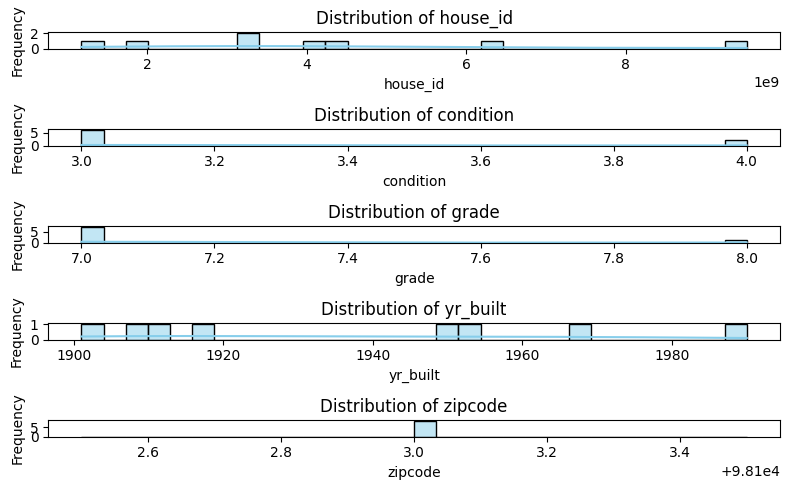

In [44]:
# Plot histograms for each continuous variable
for i, col in enumerate(continuous_vars, 1):
    plt.subplot(len(continuous_vars), 1, i)  # Create a subplot for each variable
    sns.histplot(sorted_df[col], bins=30, kde=True, color='skyblue')  # Plot histogram
    plt.title(f'Distribution of {col}')  # Set title for each subplot
    plt.xlabel(col)  # Set x-axis label
    plt.ylabel('Frequency')  # Set y-axis label

# Adjust layout for better readability
plt.tight_layout()

# Show the plots
plt.show()

In [45]:

#!pip install geojson
import geojson
import plotly.express as px



avg_latitude = sorted_df['lat'].mean()
avg_longitude = sorted_df['long'].mean()
import geojson
url_geojson = "https://raw.githubusercontent.com/OpenDataDE/State-zip-code-GeoJSON/master/wa_washington_zip_codes_geo.min.json"
fig = px.choropleth_mapbox(sorted_df, 
                           geojson=url_geojson, 
                           locations='zipcode', featureidkey='properties.ZCTA5CE10',
                           color='grade',
                           mapbox_style="open-street-map",
                           zoom=8, center={"lat": avg_latitude, "lon": avg_longitude},
                           opacity=0.5,
                           height=400,
                           width=600, 
                          )
# instead of df_import you can use ur filtered dataframe and highlight or color acc to your features of interest
fig2 = px.scatter_mapbox(sorted_df, lat="lat", lon="long", zoom=3, height=400, width= 600, hover_data='price',mapbox_style='open-street-map')

for trace in fig2.data:
    fig.add_trace(trace)
fig.show()

In [46]:
# Convert 'date' column to datetime
sorted_df['date'] = pd.to_datetime(sorted_df['date'])

In [47]:
# Assuming sorted_df is already loaded and cleaned

# Compute the correlation matrix
correlation_matrix = sorted_df.corr()

# Display the correlation matrix
print(correlation_matrix)

                date  price  house_id  bedrooms  bathrooms  sqft_living  \
date           1.000 -0.294    -0.099     0.580      0.512        0.078   
price         -0.294  1.000     0.391     0.211      0.080       -0.594   
house_id      -0.099  0.391     1.000    -0.133     -0.107       -0.270   
bedrooms       0.580  0.211    -0.133     1.000      0.333       -0.433   
bathrooms      0.512  0.080    -0.107     0.333      1.000        0.499   
sqft_living    0.078 -0.594    -0.270    -0.433      0.499        1.000   
sqft_lot       0.392  0.106    -0.203     0.468      0.497        0.129   
floors         0.359  0.226     0.377     0.000      0.408       -0.050   
waterfront       NaN    NaN       NaN       NaN        NaN          NaN   
view          -0.524  0.302    -0.343    -0.218     -0.218       -0.142   
condition     -0.626  0.145    -0.617    -0.333     -0.333       -0.047   
grade          0.148 -0.012     0.334    -0.218     -0.218       -0.008   
sqft_above     0.517  0.1

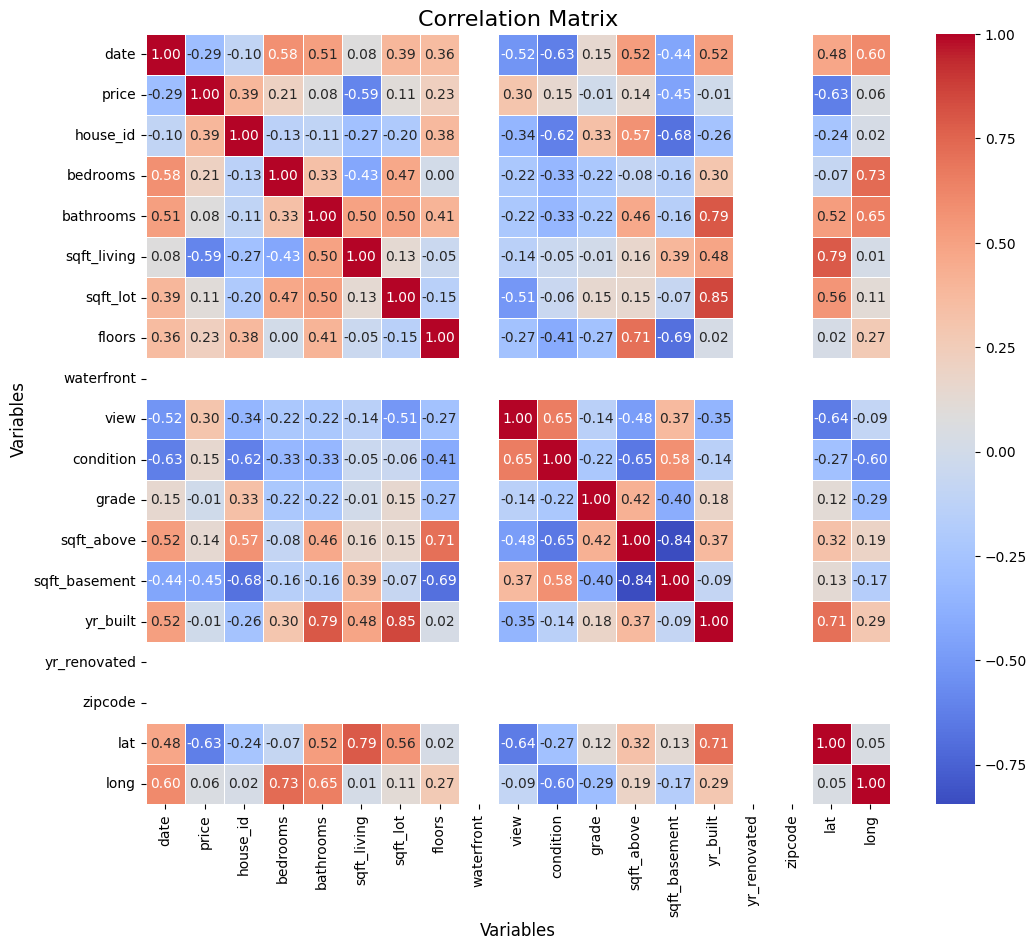

In [48]:
# Set up the plotting environment
plt.figure(figsize=(12, 10))

# Plot the correlation matrix as a heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)

# Set titles and labels
plt.title('Correlation Matrix', fontsize=16)
plt.xlabel('Variables', fontsize=12)
plt.ylabel('Variables', fontsize=12)

# Show the plot
plt.show()

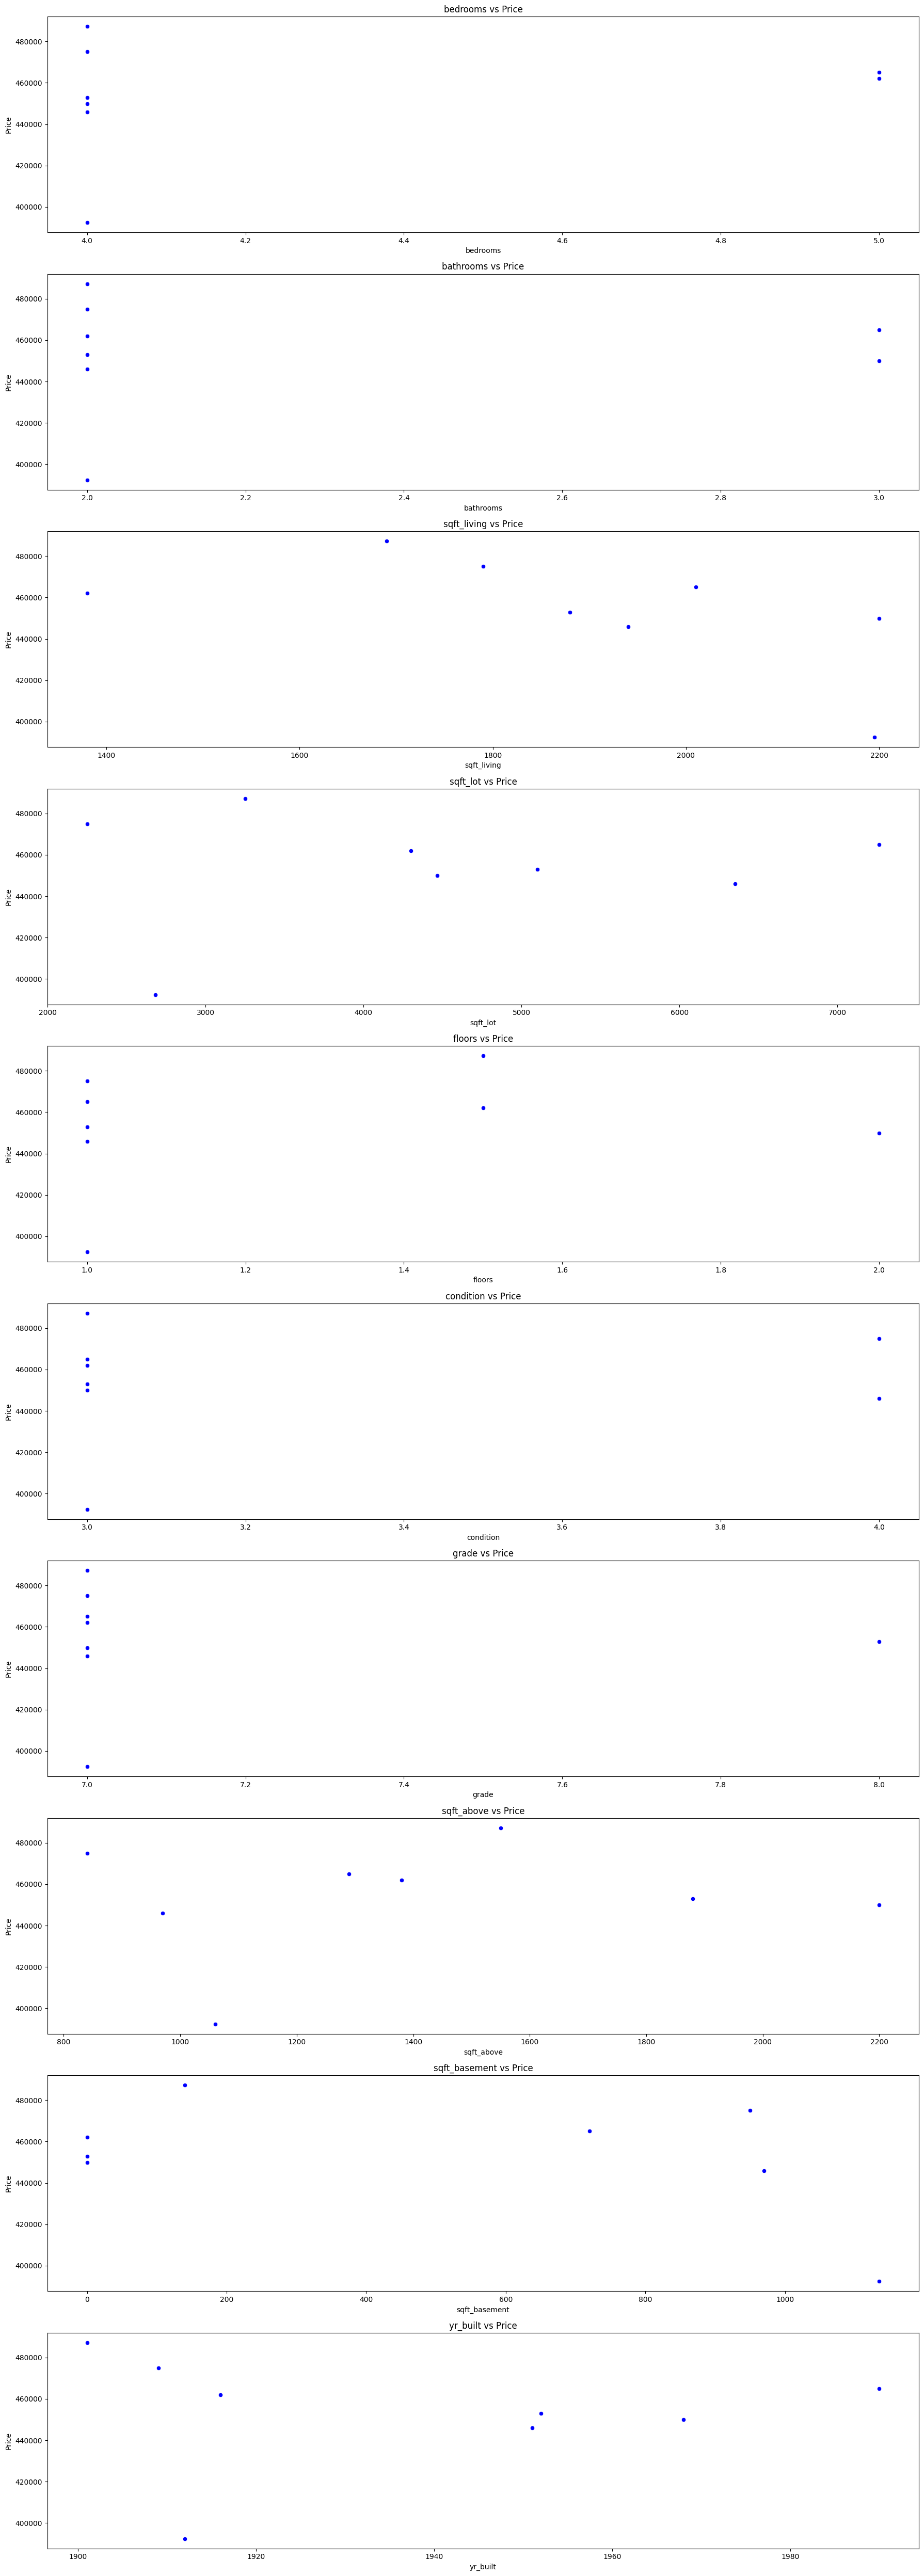

In [49]:
# Identify continuous variables excluding the target 'price'
continuous_vars = sorted_df.select_dtypes(include=['float64', 'int64']).columns
# exclude variables
continuous_vars = continuous_vars.drop('price')  # Exclude the target variable 'price'
continuous_vars = continuous_vars.drop('house_id')  # Exclude the variable 
continuous_vars = continuous_vars.drop('waterfront')  # Exclude the variable
continuous_vars = continuous_vars.drop('view')  # Exclude the variable 
continuous_vars = continuous_vars.drop('yr_renovated')  # Exclude the variable
continuous_vars = continuous_vars.drop('zipcode')  # Exclude the variable
continuous_vars = continuous_vars.drop('lat')  # Exclude the variable
continuous_vars = continuous_vars.drop('long')  # Exclude the variable


# Set up the plotting environment
plt.figure(figsize=(18, len(continuous_vars) * 5))

# Plot scatter plots for each continuous variable against 'price'
for i, col in enumerate(continuous_vars, 1):
    plt.subplot(len(continuous_vars), 1, i)
    sns.scatterplot(x=sorted_df[col], y=sorted_df['price'], color='blue')
    plt.title(f'{col} vs Price')
    plt.xlabel(col)
    plt.ylabel('Price')

# Adjust layout for better readability
plt.tight_layout()

In [50]:
# Define the conditions based on the co-relations
conditions = (
    (sorted_df['bathrooms'] == 3.0) &
    (sorted_df['bedrooms'] == 5.0) &
    (sorted_df['condition'] == 3.0)
)

In [51]:
# Filter the DataFrame based on the new conditions
filtered_df = sorted_df[conditions]

# Find the row with maximum values for 'yr_built', 'sqft_above', and 'grade'
result_row = filtered_df.loc[
    filtered_df[['yr_built', 'sqft_above', 'grade']].idxmax()
]



# Display the result
#print(result_row)

In [52]:
# display again on the geo map based on new results. 
avg_latitude = sorted_df['lat'].mean()
avg_longitude = sorted_df['long'].mean()
import geojson
url_geojson = "https://raw.githubusercontent.com/OpenDataDE/State-zip-code-GeoJSON/master/wa_washington_zip_codes_geo.min.json"
fig = px.choropleth_mapbox(result_row, 
                           geojson=url_geojson, 
                           locations='zipcode', featureidkey='properties.ZCTA5CE10',
                           color='grade',
                           mapbox_style="open-street-map",
                           zoom=8, center={"lat": avg_latitude, "lon": avg_longitude},
                           opacity=0.5,
                           height=400,
                           width=600, 
                          )
# instead of df_import you can use ur filtered dataframe and highlight or color acc to your features of interest
fig2 = px.scatter_mapbox(result_row, lat="lat", lon="long", zoom=3, height=400, width= 600, hover_data='price',mapbox_style='open-street-map')

for trace in fig2.data:
    fig.add_trace(trace)
fig.show()

In [53]:
# drop unwanted columns to make the result more readable.
# # do it here after the geo plot, because geo plot includes the locations already 
drop_cols = ['house_id', 'waterfront', 'view' , 'condition', 'grade', 'yr_renovated', 'zipcode', 'lat', 'long']

In [54]:
#display the result
result_row = result_row.drop(columns=drop_cols)
result_row

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,sqft_basement,yr_built
2,2015-01-22,465000.000,5.000,3.000,2010.000,7264.000,1.000,1290.000,720.000,1990
2,2015-01-22,465000.000,5.000,3.000,2010.000,7264.000,1.000,1290.000,720.000,1990
2,2015-01-22,465000.000,5.000,3.000,2010.000,7264.000,1.000,1290.000,720.000,1990
